# Problem 4

In [1]:
import torchvision
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
from torch.autograd import Variable 
from random import randint
from torch import optim as optim

import pickle as pkl

import matplotlib.pyplot as plt

In [2]:
#use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:

#Train and test data
mnist_train=torchvision.datasets.MNIST('mnist',
                                       train=True,
                                       download=True,
                                       transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.5,), (0.5, ))
                                       ]))


mnist_= torchvision.datasets.MNIST('mnist',
                          train=False,
                          download=True,
                          transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.5, ), (0.5, ))
                          ])
                          )

In [4]:
batch_size = 64

#creating a dataloader
train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
test_dataloader = DataLoader(mnist_, batch_size=batch_size)
flatten = nn.Flatten()
#Testing the size of each input
print(len(test_dataloader))
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print('flatten shape', flatten(X).shape)
    break

157
Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
flatten shape torch.Size([64, 784])



 Epoch 0: descriminator loss 0.16893243789672852, generator loss 4.272493839263916

 Epoch 1: descriminator loss 0.07384811341762543, generator loss 5.773636341094971

 Epoch 2: descriminator loss 0.016820674762129784, generator loss 8.008273124694824

 Epoch 3: descriminator loss 0.008194942958652973, generator loss 9.776795387268066

 Epoch 4: descriminator loss 0.005464314017444849, generator loss 10.936772346496582

 Epoch 5: descriminator loss 0.0061494349502027035, generator loss 11.464532852172852

 Epoch 6: descriminator loss 0.0061176554299890995, generator loss 12.434694290161133

 Epoch 7: descriminator loss 0.0036422954872250557, generator loss 13.627851486206055

 Epoch 8: descriminator loss 0.003305415390059352, generator loss 14.543724060058594

 Epoch 9: descriminator loss 0.004254806786775589, generator loss 15.439936637878418

 Epoch 10: descriminator loss 0.0020125177688896656, generator loss 16.383346557617188

 Epoch 11: descriminator loss 0.0015580521430820227, g

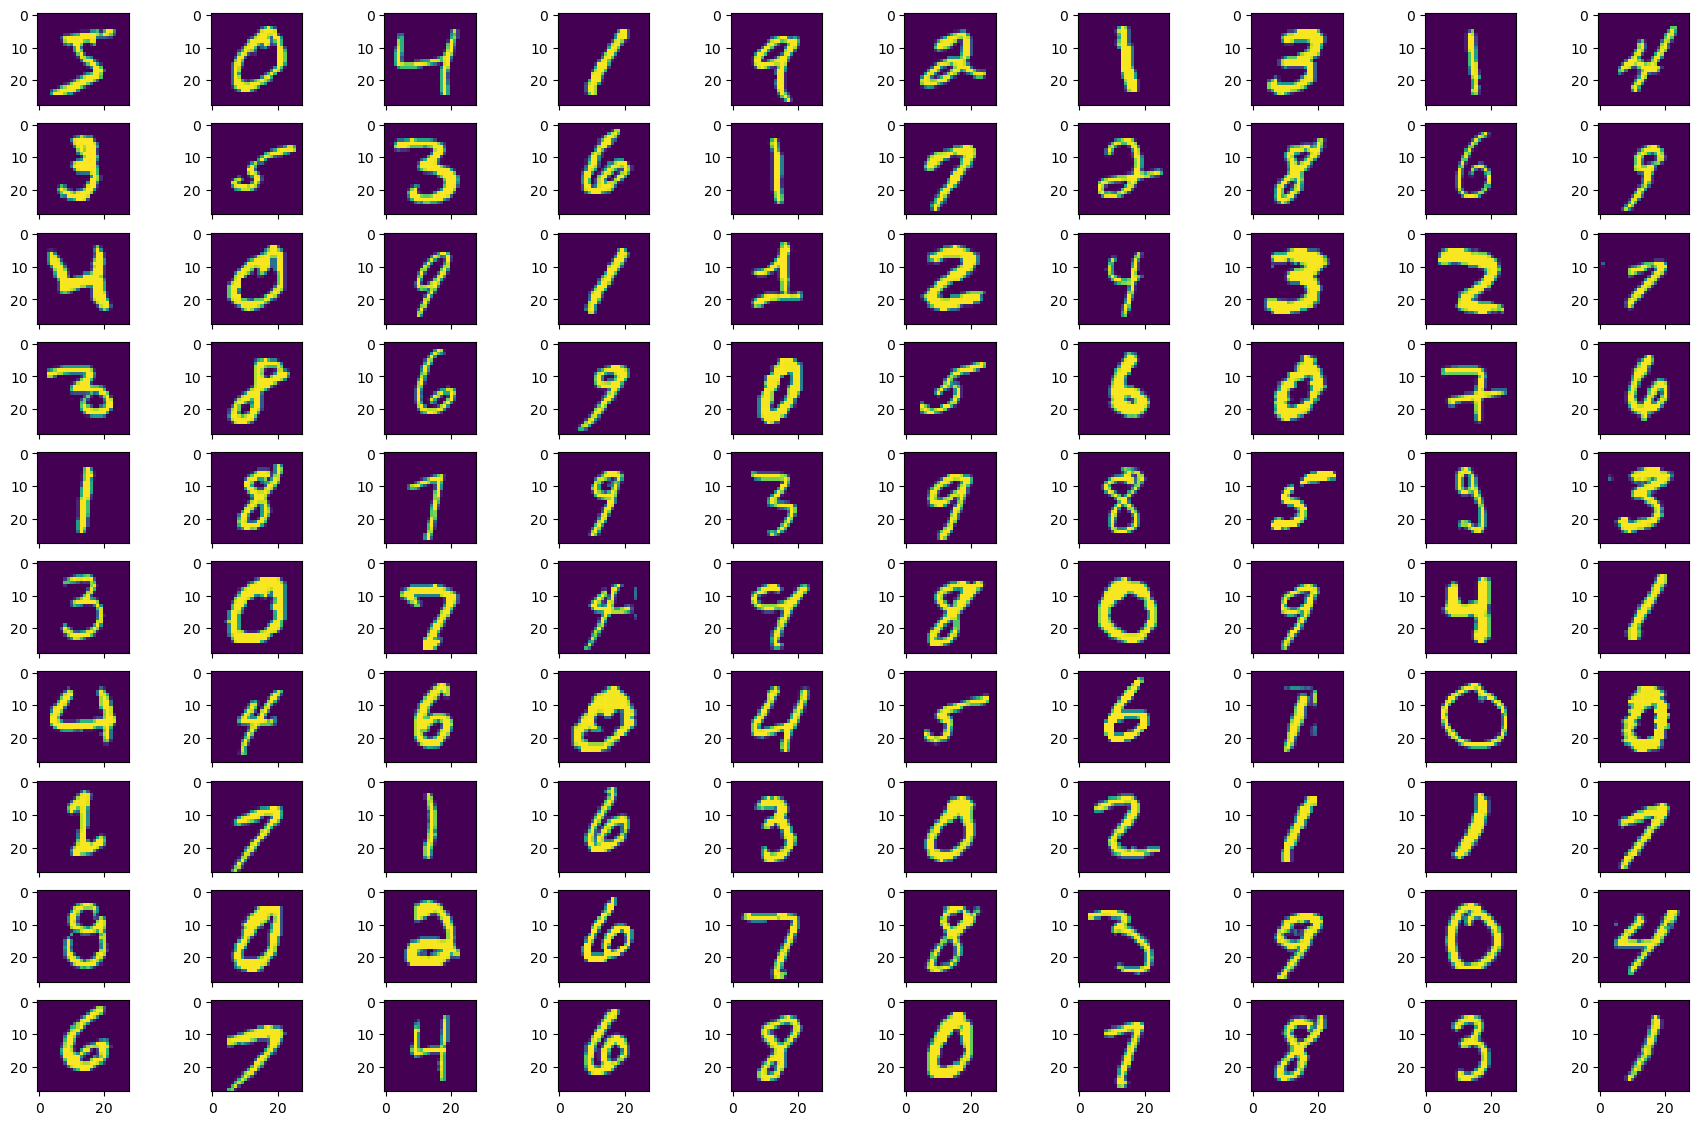

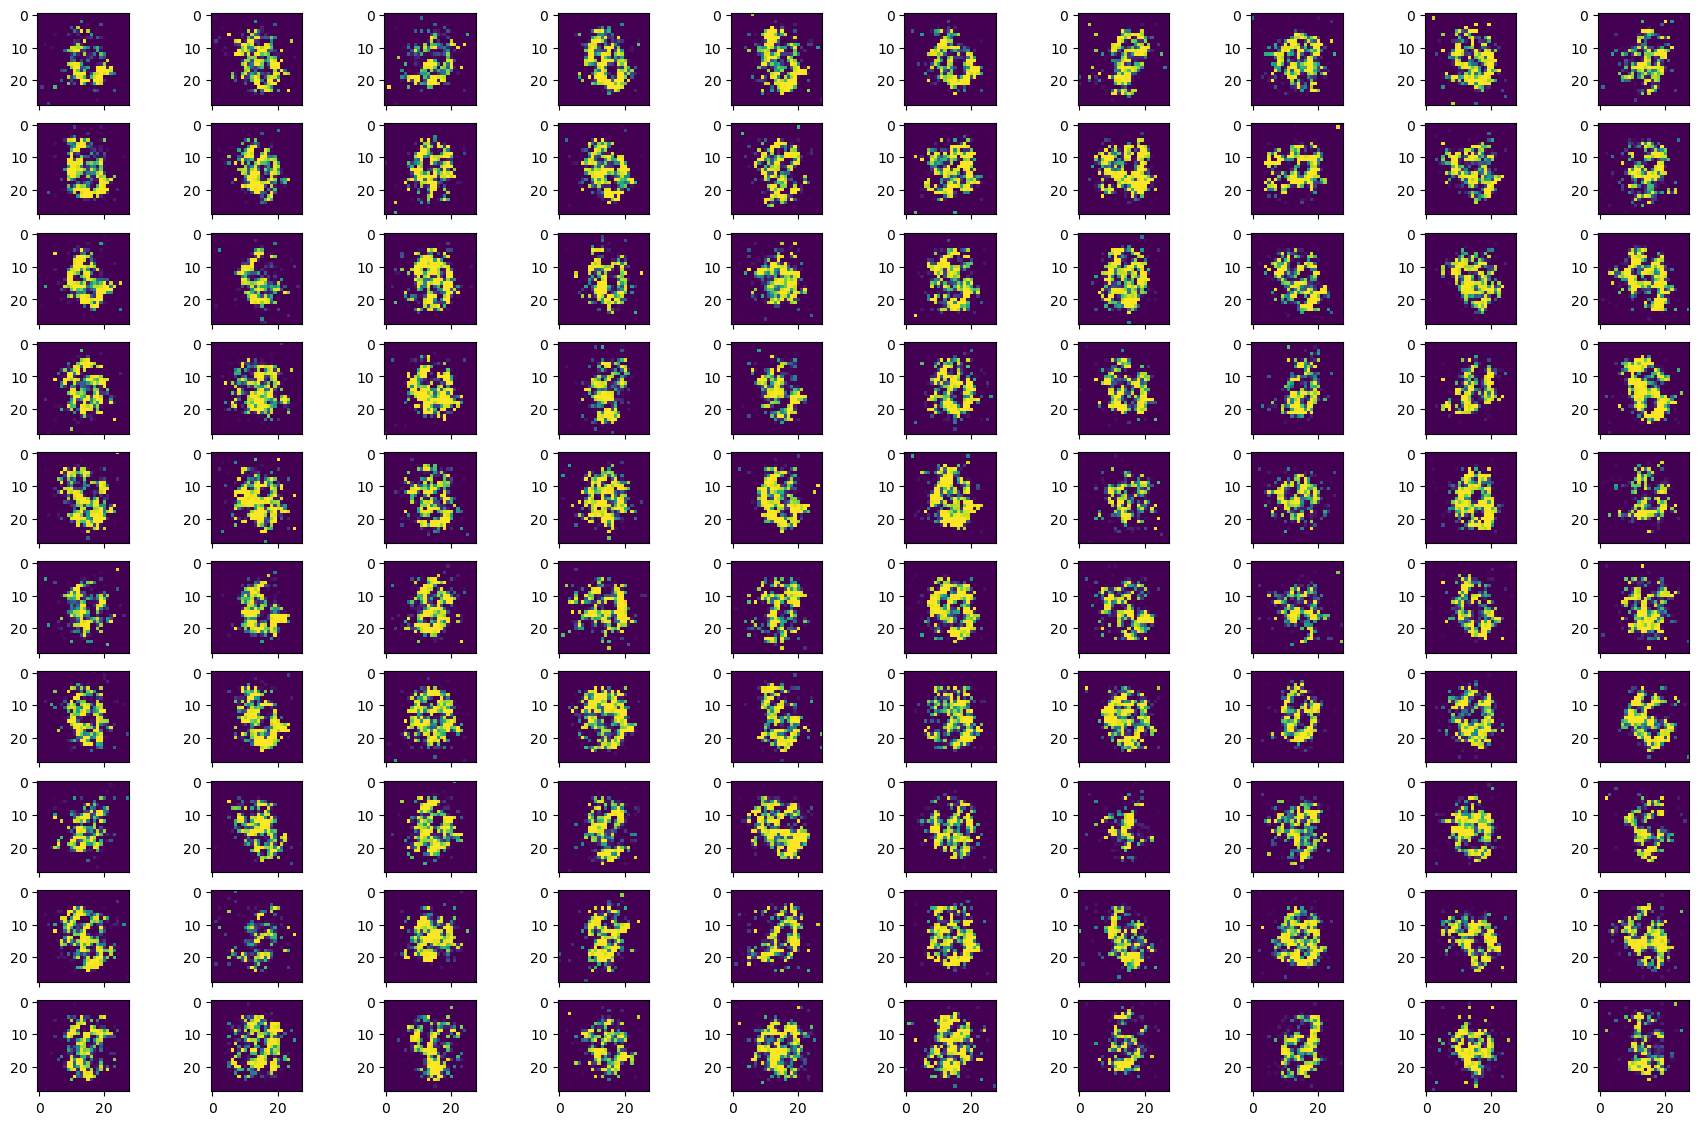

In [10]:
class PrepareData(Dataset):
    def __init__(self, X, y):
        super(PrepareData, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    
    
def stack_data(data, save=True, type_of='train', real=False):
    new_x_tensor = []
    new_y_tensor = []
    
    for x, y in data:
        # x_new = x[:, 10:20, 10:20]
        # x = torch.flatten(x, start_dim=1)
        y = torch.tensor(y, dtype=torch.long)
        
        new_x_tensor.append(x)
        new_y_tensor.append(y)
        
    new_x_tensor = torch.stack(new_x_tensor)
    new_x_tensor = new_x_tensor.squeeze()
    
    new_y_tensor = torch.stack(new_y_tensor)
    
    if save == True:
        torch.save(new_x_tensor, f'hw5_raw_{type_of}_x.pt')
        torch.save(new_y_tensor, f'hw5_raw_{type_of}_y.pt')
        
    return new_x_tensor, new_y_tensor


def plot_image_single(data_loader):
    for x,_ in data_loader:
        plt.imshow(x.numpy()[0][0], cmap='gray')
        break


class GeneratorModel(nn.Module):
    def __init__(self, parameters):
        super(GeneratorModel, self).__init__()
        
        self.l1 = nn.Linear(parameters['in_dim'], #100
                            parameters['hidden_dim_1'] #200
                           )
        self.l2 = nn.Linear(parameters['hidden_dim_1'], 
                            parameters['hidden_dim_2']) #400
        self.l3 = nn.Linear(parameters['hidden_dim_2'], 
                            parameters['out_dim']) #784
        
        
    def forward(self, x):
        gen_x = torch.randn(parameters['batch'], 100)
        x = torch.cat((x, gen_x), 1)
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.tanh(self.l3(x))
        
        return x, gen_x
    
    
class DiscriminatorModel(nn.Module):
    def __init__(self, parameters):
        super(DiscriminatorModel, self).__init__()
        

        self.l1 = nn.Linear(parameters['out_dim'] + 100, #884
                            parameters['hidden_dim_2']
                           )
        self.l2 = nn.Linear(parameters['hidden_dim_2'], 
                            parameters['hidden_dim_1'])
        self.l3 = nn.Linear(parameters['hidden_dim_1'], 
                            parameters['in_dim_des'])
        self.l4 = nn.Linear(parameters['in_dim_des'], 
                            parameters['out_dim_des'])
        
        
    def forward(self, x, image, fake=False):
        if fake == True:
            x_new = image
        else:
            x_new = image[:, 10:20, 10:20]
            x_new = torch.flatten(x_new, start_dim=1)
        
        x = torch.cat((x, x_new), 1)
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.sigmoid(self.l4(x))
        
        return x, x_new
    

def create_dataloader(x, y, batchsize):
    data = PrepareData(x, y)
   
    dataloader = DataLoader(dataset=data, shuffle=False, 
                      batch_size=batchsize)
    
    return dataloader


def prepare_data(train=mnist_train, 
                 label=True,
                 batchsize=100
                ):
    train_data_x, train_data_y = stack_data(mnist_train)
    
    train_loader = create_dataloader(train_data_x,
                                     train_data_y,
                                     batchsize)
    
    return train_loader  #, data_for_generator

def test(test_dataloader, model, loss, y):
    model.eval()
    model.to(device)
    
    total_loss = 0
    correct = 0
    size = len(test_dataloader.dataset)
    
    with torch.no_grad():
        for j, (x_test, y_test) in enumerate(test_dataloader):
            pred = model(x_test, y_test).to(device)
            
            total_loss += loss(pred, y).item()
            pred = torch.where(pred >0.5, 1, 0)
            
            correct += (pred == y).type(torch.float).sum().item()
        
    total_loss /= size
    correct /= size
    
    print(f'\n --Test error real images: {total_loss} --')
    
    return correct
        

def generat_label():
    labels = []

    for r in range(10):
        for rr in range(10):
            labels.append(r)
        
        
    return torch.tensor(labels)
    
    
def test_fake(generator, discriminator, loss, parameters):
    generator.eval()
    discriminator.eval()
    
    total_loss = 0
    correct = 0
    size = 60000
    
    with torch.no_grad():
        for i in range(600):
            noise = torch.randn(parameters['batch'], 100)
            # fake_labels = torch.randint(0, 10, (parameters['batch'],))
            fake_labels = generat_label()
            generated_data = generator(noise, fake_labels)

            y_test = torch.zeros(parameters['batch']).reshape(100, 1).type(
                        torch.float)

            pred = discriminator(generated_data, 
                                 fake_labels)
            total_loss += loss(pred, y_test).item()
            
            pred = torch.where(pred >0.5, 1, 0)
            
            # correct += (pred == y_test).type(torch.float).sum().item()
            correct += torch.eq(pred, y_test).sum().item()
    
    total_loss /= size
    correct /= size 
    
    print(f'\n --Test error fake images: {total_loss} --')

    return correct


def plot_images(column, row, 
                fig_name, input_x
               ):
    j = 0
    k = 0
    indexes = 0
    fig, ax = plt.subplots(row, column, figsize=(22, 14), sharex=True)

    for i in range(row):
        for j in range(column):
            new_ax = ax[i, j]
            
            new_ax.imshow(input_x[indexes].detach().numpy())
            indexes = indexes + 1
            
    fig.savefig(f'{fig_name}', 
            facecolor='white', 
            transparent=False)

    plt.show()
    
def process(parameters):
    #Real image
    train_dataloader = prepare_data(train=mnist_train,
                                    label=False,
                                    batchsize=parameters['batch']
                                   )
                                      
    test_dataloader = prepare_data(train=mnist_,
                                    label=False,
                                    batchsize=parameters['batch']
                                   )
    all_pred = []
    
#     # for  y in label_loader:
#     #     print(y.shape)
#     #     break
    
    generator = GeneratorModel(parameters)
    discriminator = DiscriminatorModel(parameters)
    
    loss = nn.BCELoss()
    loss_mse = nn.MSELoss()
    discriminator_optimizer = optim.Adam(
        discriminator.parameters(), lr=0.0001)
    generator_optimizer = optim.Adam(
        generator.parameters(), lr=0.0001)

    for t in range(parameters['epoch']):
        total_g_loss = []
        total_d_loss = []
        
        for i, (x, y) in enumerate(train_dataloader):
            x_new = x[:, 10:20, 10:20]
            x_new = torch.flatten(x_new, start_dim=1)
            
            x_784 = torch.flatten(x, start_dim=1)
            
           
            #Generator part, x shape = 100 * 100
            generation_data, gen_cond = generator(x_new)
            
        #######################################################
            #Discriminator part
            discriminator_optimizer.zero_grad()
            
            true_labels = torch.ones(parameters['batch']).reshape(100, 1).type(
                torch.float)
            
            descrimination_data, des_cond = discriminator(x_784, x)
            
            descrimination_loss = loss(descrimination_data, 
                                       true_labels)
            
            descrimination_generation_data, des_gen_cond = discriminator(
                generation_data.detach(),
                gen_cond, fake=True)
            
            zero_y = torch.zeros(parameters['batch']).reshape(100, 1).type(
                torch.float)
            descrimination_generation_loss = loss(descrimination_generation_data,
                                                  zero_y)
            
            discriminator_loss = (descrimination_loss + descrimination_generation_loss) / 2
            
            
            discriminator_loss.backward()
            discriminator_optimizer.step()

            total_d_loss.append(discriminator_loss.data.item())
                              
            #Generator training
            generator_optimizer.zero_grad()
            
            generation_data, gen_cond = generator(x_new)
            descrimination_generation_data, des_gen_cond = discriminator(
                generation_data, gen_cond, fake=True)
            
            generation_data = generation_data.view(
                    100, 28, 28)
            
            x_gen = generation_data[:, 10:20, 10:20]
            x_gen = torch.flatten(x_gen, start_dim=1)
            
            generator_loss = loss(descrimination_generation_data, 
                                  true_labels) + loss_mse(des_gen_cond, x_gen)
            
            generator_loss.backward()
            generator_optimizer.step()
        
            total_g_loss.append(generator_loss.data.item())
                                                          
                                                 
            
        mean_d_loss = torch.mean(torch.FloatTensor(total_d_loss))
        mean_g_loss = torch.mean(torch.FloatTensor(total_g_loss))

        print(f'\n Epoch {t}: descriminator loss {mean_d_loss}, generator loss {mean_g_loss}')
        
#         y_test = torch.ones(parameters['batch']).reshape(100, 1).type(
#                 torch.float)
        
#         correct_true = test(test_dataloader, discriminator, loss, y_test)
#         correct_false = test_fake(generator, discriminator, loss, parameters)
        
        # print(f'\n correct -- {correct_true}, fake -- {correct_false}')
        
#         all_pred.append([t, correct_true, correct_false])
        
        if t  == 199:
            print(f'\n Epoch {t}:')
            
            with torch.no_grad():
                for tt, (x_test, y_test) in enumerate(test_dataloader):
                    x_new = x_test[:, 10:20, 10:20]
                    x_new = torch.flatten(x_new, start_dim=1)
                
                    generated_data, cond = generator(x_new)
                    
                    
                    plot_images(10, 10, 'hw5-qns4-original.png', 
                               x_test)
                
                    # pred = discriminator(generated_data, 
                    #                      fake_labels)
                    generated_data = generated_data.view(
                        100, 28, 28)

#                     for rr, x_test in enumerate(generated_data):
#                         # print(fake_labels[rr].item())
#                         plt.imshow(x_test.detach().numpy(), 
#                                    interpolation='nearest',cmap='gray')
#                         plt.show()

#                         break
                    plot_images(10, 10, 'hw5-qns4.png', 
                                generated_data.detach())
                    break

       
           
#             break
        # break
                                        

        
        
parameters = {
    'in_dim': 200,
    'hidden_dim_1': 200,
    'hidden_dim_2': 400,
    'in_dim_des': 100,
    'out_dim': 784,
    'out_dim_des': 1,
    # 'baseline_model': 'hw_4_baseline.model',
    'batch': 100,
    'num_layers': 2,
    'type_init': 'xavier',
    'activation': 'ReLU',
    'dropout': None,
    "lr_rate": 0.01,
    'epoch': 200,
    'latent_dim': 3,
    'd_vector': 100
}
   
    
process(parameters)
